# **End-to-End Market Basket Analysis Groceries Dataset**

**Nama: Hashfi Putraza Hikmat**

**Dataset: Grecories Dataset**

**Kelas: JCDSBDGAM-09**

## **Import Library & Load Dataset**

### **Import Library**

In [1]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Library khusus Market Basket Analysis
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Setting visualisasi
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings('ignore')

### **Load Dataset**

**Link Dataset:**
https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset

In [3]:
base_dir = "D:\PENTING\Purwadhika\Job Connector Data Science\Materials\Modul 3\Portofolio\\"
path = base_dir + "Groceries_dataset.csv"
df = pd.read_csv(path)

### **Preview Data**

In [4]:
# Melihat 5 baris pertama & terakhir
display(df.head())
display(df.tail())

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,5/1/2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12/12/2015,other vegetables
4,3037,1/2/2015,whole milk


,Member_number,Date,itemDescription
38760,4471,8/10/2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,3/12/2014,fruit/vegetable juice
38764,1521,26-12-2014,cat food


In [5]:
# Melihat informasi tipe data dan jumlah baris/kolom
print(f"Dimensi Data: {df.shape[0]} baris dan {df.shape[1]} kolom")
print("\nInfo Data:")
df.info()

Dimensi Data: 38765 baris dan 3 kolom

Info Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


## **Introduction (Business Understanding)**

### **Introduction (Business Understanding)**

**Context**

Dataset ini berisi data transaksi dari toko kelontong (groceries). Analisis ini bertujuan untuk menemukan pola belanja konsumen menggunakan teknik data mining.

**Business Problem**

Toko ritel seringkali menghadapi masalah penjualan yang stagnan atau kesulitan dalam menentukan strategi promosi yang tepat. Tantangannya adalah kita tidak tahu barang apa yang cenderung dibeli bersamaan oleh pelanggan.

**Goals**

Tujuan utama dari analisis ini adalah:
1. Meningkatkan **Average Basket Size** (rata-rata jumlah barang per transaksi).
2. Menemukan pola **Bundling** produk yang efektif.
3. Memberikan rekomendasi penempatan barang (Store Layout).

**Metric Selection**

Kita akan menggunakan metric berikut untuk evaluasi:
* **Support:** Seberapa populer suatu kombinasi barang.
* **Confidence:** Seberapa besar kemungkinan barang Y dibeli jika barang X dibeli.
* **Lift:** Seberapa kuat hubungan antar barang (Lift > 1 menunjukkan hubungan positif yang valid).

## **Data Preprocessing & Cleaning**

### **Data Type Conversion**
**Kolom Date harus diubah ke format datetime agar bisa diolah.**

In [6]:
# Mengubah kolom Date menjadi datetime
# Kita hapus format='%d-%m-%Y' dan ganti dengan dayfirst=True & format = mixed
# agar pandas otomatis menangani campuran format '/' dan '-'
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, format='mixed')

# Cek hasil konversi dan tampilkan beberapa contoh
print("Tipe data Date setelah konversi:", df['Date'].dtype)
print("\nContoh data tanggal setelah perbaikan:")
print(df['Date'].head())

Tipe data Date setelah konversi: datetime64[ns]

Contoh data tanggal setelah perbaikan:
0   2015-07-21
1   2015-01-05
2   2015-09-19
3   2015-12-12
4   2015-02-01
Name: Date, dtype: datetime64[ns]


### **Handling Missing Values**

In [7]:
# Mengecek apakah ada missing values
missing_values = df.isnull().sum()
print("Jumlah Missing Values per kolom:")
print(missing_values)

Jumlah Missing Values per kolom:
Member_number      0
Date               0
itemDescription    0
dtype: int64


### **Handling Duplicates**

In [8]:
# Cek duplikat
duplicates = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicates}")

# Menghapus duplikat jika ada
if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("Duplikat telah dihapus.")

Jumlah data duplikat: 759
Duplikat telah dihapus.


### **Data Cleaning (String Manipulation)**
**Membersihkan spasi berlebih pada nama barang agar "milk" dan "milk " dianggap sama.**

In [9]:
# Membersihkan whitespace pada kolom itemDescription
df['itemDescription'] = df['itemDescription'].str.strip()

### **Cell 11 (Code): Creating Unique Transaction ID**
**Dataset ini tidak punya InvoiceNo. Kita asumsikan 1 Member belanja di Tanggal yang sama = 1 Transaksi.**

In [10]:
# Membuat kolom Transaction_ID gabungan dari Member_number dan Date
df['Transaction_ID'] = df['Member_number'].astype(str) + '_' + df['Date'].astype(str)

print(f"Jumlah Transaksi Unik: {df['Transaction_ID'].nunique()}")
display(df[['Member_number', 'Date', 'Transaction_ID']].head())

Jumlah Transaksi Unik: 14963


,Member_number,Date,Transaction_ID
0,1808,2015-07-21,1808_2015-07-21
1,2552,2015-01-05,2552_2015-01-05
2,2300,2015-09-19,2300_2015-09-19
3,1187,2015-12-12,1187_2015-12-12
4,3037,2015-02-01,3037_2015-02-01


## **EDA (Exploratory Data Analysis)**

### **Top 10 Bes Selling Items**

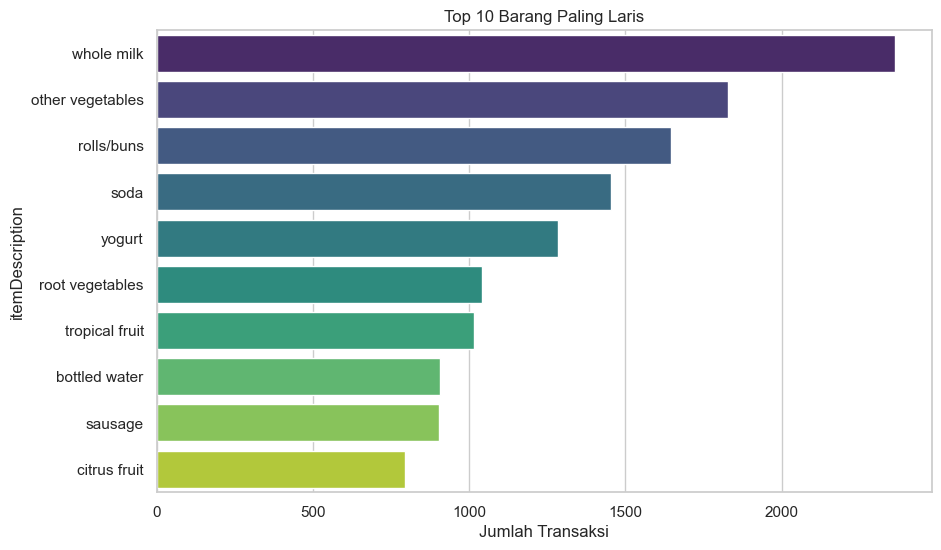

In [11]:
plt.figure(figsize=(10, 6))
top_items = df['itemDescription'].value_counts().head(10)
sns.barplot(x=top_items.values, y=top_items.index, palette='viridis')
plt.title('Top 10 Barang Paling Laris')
plt.xlabel('Jumlah Transaksi')
plt.show()

### **Bottom 10 Least Selling Items**

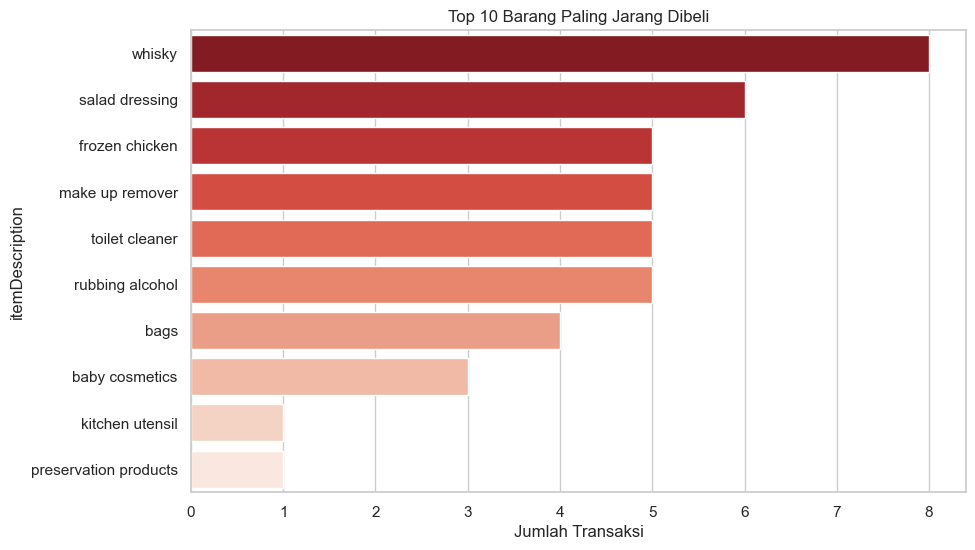

In [12]:
plt.figure(figsize=(10, 6))
bottom_items = df['itemDescription'].value_counts().tail(10)
sns.barplot(x=bottom_items.values, y=bottom_items.index, palette='Reds_r')
plt.title('Top 10 Barang Paling Jarang Dibeli')
plt.xlabel('Jumlah Transaksi')
plt.show()

### **Monthly Sales Trend**

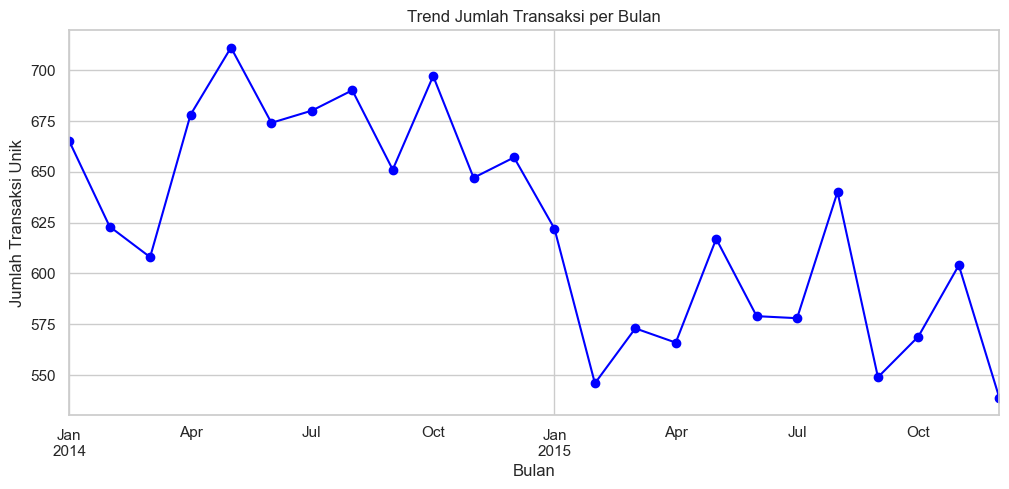

In [13]:
df['Month_Year'] = df['Date'].dt.to_period('M')
monthly_trend = df.groupby('Month_Year')['Transaction_ID'].nunique()

plt.figure(figsize=(12, 5))
monthly_trend.plot(kind='line', marker='o', color='blue')
plt.title('Trend Jumlah Transaksi per Bulan')
plt.ylabel('Jumlah Transaksi Unik')
plt.xlabel('Bulan')
plt.grid(True)
plt.show()

## **Basket Transformation**

### **Creating Basket Matrix** 
**Mengubah data menjadi bentuk pivot (Baris = Transaksi, Kolom = Barang).**

In [14]:
# Grouping by Transaction_ID dan itemDescription
basket = (df.groupby(['Transaction_ID', 'itemDescription'])['itemDescription']
          .count().unstack().reset_index().fillna(0)
          .set_index('Transaction_ID'))

print("Dimensi Matrix Basket:", basket.shape)
# Menampilkan sebagian kecil kolom untuk pengecekan
display(basket.iloc[:, :5].head())

Dimensi Matrix Basket: (14963, 167)


itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics
Transaction_ID,,,,,
1000_2014-06-24,0.000,0.000,0.000,0.000,0.000
1000_2015-03-15,0.000,0.000,0.000,0.000,0.000
1000_2015-05-27,0.000,0.000,0.000,0.000,0.000
1000_2015-07-24,0.000,0.000,0.000,0.000,0.000
1000_2015-11-25,0.000,0.000,0.000,0.000,0.000


### **Binary Encoding**
**Mengubah jumlah barang menjadi 0 (tidak beli) atau 1 (beli). Apriori hanya butuh 0/1.**

In [15]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_encoded = basket.applymap(encode_units)

print("Encoding selesai.")
display(basket_encoded.head())

Encoding selesai.


itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,curd,curd cheese,decalcifier,dental care,dessert,detergent,dish cleaner,dishes,dog food,domestic eggs,female sanitary products,finished products,fish,flour,flower (seeds),flower soil/fertilizer,frankfurter,frozen chicken,frozen dessert,frozen fish,frozen fruits,frozen meals,frozen potato products,frozen vegetables,fruit/vegetable juice,grapes,hair spray,ham,hamburger meat,hard cheese,herbs,honey,house keeping products,hygiene articles,ice cream,instant coffee,jam,ketchup,kitchen towels,kitchen utensil,light bulbs,liqueur,liquor,liquor (appetizer),liver loaf,long life bakery product,make up remover,male cosmetics,margarine,mayonnaise,meat,meat spreads,misc. beverages,mustard,napkins,newspapers,nut snack,nuts/prunes,oil,onions,organic products,organic sausage,other vegetables,packaged fruit/vegetables,pasta,pastry,pet care,photo/film,pickled vegetables,pip fruit,popcorn,pork,pot plants,potato products,preservation products,processed cheese,prosecco,pudding powder,ready soups,red/blush wine,rice,roll products,rolls/buns,root vegetables,rubbing alcohol,rum,salad dressing,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Transaction_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000_2014-06-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1000_2015-03-15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1000_2015-05-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1000_2015-07-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1000_2015-11-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **Modeling (Apriori)**

### **Generate Frequent Itemsets** 
**Kita gunakan `min_support=0.001` karena data groceries biasanya sangat menyebar (sparse), jadi 1% mungkin terlalu tinggi.**

In [16]:
# Menjalankan algoritma Apriori
# min_support rendah karena variasi barang sangat banyak
frequent_itemsets = apriori(basket_encoded, min_support=0.001, use_colnames=True)

frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Sorting berdasarkan support tertinggi
print(f"Ditemukan {len(frequent_itemsets)} frequent itemsets.")
display(frequent_itemsets.sort_values(by='support', ascending=False).head(10))

Ditemukan 750 frequent itemsets.


,support,itemsets,length
146,0.158,(whole milk),1
90,0.122,(other vegetables),1
109,0.110,(rolls/buns),1
123,0.097,(soda),1
147,0.086,(yogurt),1
110,0.070,(root vegetables),1
139,0.068,(tropical fruit),1
10,0.061,(bottled water),1
115,0.060,(sausage),1
28,0.053,(citrus fruit),1


### **Generate Association Rules** 
**Kita cari aturan dengan Lift > 1 (hubungan positif).**

In [17]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print(f"Ditemukan {len(rules)} aturan asosiasi.")
display(rules.head())

Ditemukan 240 aturan asosiasi.


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(tropical fruit),(UHT-milk),0.068,0.021,0.002,0.023,1.061,1.000,0.000,1.001,0.061,0.018,0.001,0.047
1,(UHT-milk),(tropical fruit),0.021,0.068,0.002,0.072,1.061,1.000,0.000,1.004,0.058,0.018,0.004,0.047
2,(beef),(brown bread),0.034,0.038,0.002,0.045,1.203,1.000,0.000,1.008,0.175,0.022,0.008,0.043
3,(brown bread),(beef),0.038,0.034,0.002,0.041,1.203,1.000,0.000,1.007,0.176,0.022,0.007,0.043
4,(beef),(citrus fruit),0.034,0.053,0.002,0.053,1.000,1.000,0.000,1.000,0.000,0.021,0.000,0.044


## **Evaluation & Insight**

### **Filtering Strong Rules** 
**Kita filter aturan yang memiliki Confidence minimal 5% dan Lift minimal 1.2 (bisa diubah sesuai hasil).**

In [18]:
# Filter: Confidence >= 0.05 dan Lift >= 1.2
best_rules = rules[(rules['confidence'] >= 0.05) & (rules['lift'] >= 1.2)]

# Urutkan berdasarkan Lift tertinggi
best_rules_sorted = best_rules.sort_values(by='lift', ascending=False)

print("Top Rules Hasil Filter:")
display(best_rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

Top Rules Hasil Filter:


,antecedents,consequents,support,confidence,lift
234,"(whole milk, yogurt)",(sausage),0.001,0.132,2.183
235,"(whole milk, sausage)",(yogurt),0.001,0.164,1.912
86,(specialty chocolate),(citrus fruit),0.001,0.088,1.654
236,"(yogurt, sausage)",(whole milk),0.001,0.256,1.620
123,(flour),(tropical fruit),0.001,0.110,1.617
20,(beverages),(sausage),0.002,0.093,1.537
228,"(soda, whole milk)",(sausage),0.001,0.092,1.524
168,(napkins),(pastry),0.002,0.079,1.519
183,(processed cheese),(root vegetables),0.001,0.105,1.513
149,(hard cheese),(pip fruit),0.001,0.073,1.483


### **Visualizing Rules (Scatterplot)**

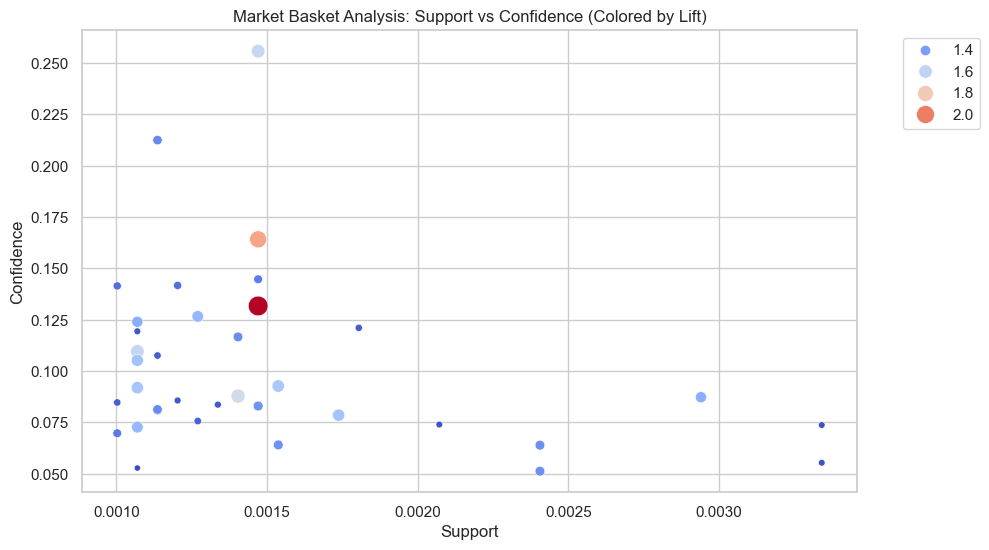

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="support", y="confidence", size="lift", data=best_rules, hue="lift", palette="coolwarm", sizes=(20, 200))
plt.title('Market Basket Analysis: Support vs Confidence (Colored by Lift)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

### **Deep Dive Example** 
**Mari kita lihat secara spesifik apa yang dibeli orang jika mereka membeli "whole milk" (karena ini barang paling laku).**

In [20]:
# Mencari pasangan produk untuk 'whole milk'
target_item = 'whole milk'
milk_rules = rules[rules['antecedents'].apply(lambda x: target_item in x)]

milk_rules_sorted = milk_rules.sort_values(by='lift', ascending=False).head(5)
display(milk_rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

,antecedents,consequents,support,confidence,lift
234,"(whole milk, yogurt)",(sausage),0.001,0.132,2.183
235,"(whole milk, sausage)",(yogurt),0.001,0.164,1.912
237,(whole milk),"(yogurt, sausage)",0.001,0.009,1.620
228,"(soda, whole milk)",(sausage),0.001,0.092,1.524
216,"(rolls/buns, whole milk)",(sausage),0.001,0.081,1.348


## **Business Recommendations**

### **Business Recommendations**

Berdasarkan hasil *Association Rule Mining* dengan metrik Lift tertinggi, ditemukan pola perilaku konsumen yang spesifik pada produk **Dairy (Produk Susu)** dan **Meat (Daging)** maka berikut adalah rekomendasi strategi bisnis:

1.  **Bundling Strategy:**
* **Insight**: Ditemukan hubungan kuat di mana pelanggan yang membeli Whole Milk dan Yogurt memiliki kemungkinan tinggi (Lift: 2.18) untuk juga membeli Sausage (Sosis).
* **Saran**: Buat paket bundling **"Breakfast Trio"** yang berisi Susu, Yogurt, dan Sosis dengan harga diskon 5-10%. Ini akan mendorong penjualan Sosis bagi mereka yang awalnya hanya berniat beli produk susu.

2.  **Store Layout Optimization:**
* **Insight** Produk **Sosis** sering menjadi pembelian ikutan (consequent) dari kombinasi Susu dan Yogurt.
* **Saran:** Meskipun Sosis adalah produk daging (biasanya di freezer daging) dan Susu/Yogurt di pendingin dairy, pertimbangkan untuk menempatkan **kulkas kecil berisi Sosis Premium** di dekat lorong Susu & Yogurt (Cross-merchandising).

3.  **Targeted Marketing (Promosi):**
* **Insight**: Pelanggan yang keranjangnya sudah berisi Susu dan Roti atau Susu dan Yogurt, sangat potensial membeli Sosis.
* Action: Jika menggunakan aplikasi belanja, saat pelanggan memasukkan Susu dan Yogurt ke keranjang, munculkan pop-up rekomendasi seperti, **"Lengkapi sarapanmu dengan Sosis, diskon 20% khusus hari ini!"**

## **Save Result & Link Looker**

### **Save Result**

In [21]:
# Menyimpan hasil rules ke CSV untuk laporan
best_rules_sorted.to_csv('MBA_Groceries_Result.csv', index=False)

### **Link Looker**
https://lookerstudio.google.com/s/sIqQGQnY7pY